In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from hep_ml import metrics
from utils import check_correlation
from mass_correlation_utils import *

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Loading
`training.csv` is a mixture of simulated signal, real background.

In [2]:
train_df = pd.read_csv('Data/training.csv.gz', sep=',')

In [3]:
train_df.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


In [4]:
train_df.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'production',
       'signal', 'mass', 'min_ANNmuon'],
      dtype='object')

In [5]:
test_df = pd.read_csv('Data/test.csv.gz', sep=',', index_col='id')

In [6]:
test_df.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,
14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,...,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,...,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,...,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,...,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,...,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


In [7]:
test_df.columns

Index(['LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits'],
      dtype='object')

# Baseline Model

In [8]:
train, valid = train_test_split(train_df, test_size=0.3, random_state=13)

Feature selction for training.

In [9]:
variables = list(set(train_df.columns) - {'id', 'signal', 'mass', 'production', 'min_ANNmuon'})
print(variables)

['p2_IsoBDT', 'isolationc', 'LifeTime', 'isolationa', 'CDF3', 'ISO_SumBDT', 'FlightDistance', 'VertexChi2', 'isolationd', 'SPDhits', 'p2_pt', 'p2_eta', 'IP_p0p2', 'p0_p', 'CDF1', 'p2_track_Chi2Dof', 'p0_IP', 'IP', 'IPSig', 'p0_IPSig', 'isolationb', 'p1_p', 'p0_pt', 'CDF2', 'p1_track_Chi2Dof', 'dira', 'p2_IPSig', 'pt', 'FlightDistanceError', 'DOCAone', 'isolationf', 'DOCAthree', 'p0_eta', 'p2_IP', 'IP_p1p2', 'p1_IsoBDT', 'p2_p', 'iso', 'p1_eta', 'DOCAtwo', 'p0_IsoBDT', 'p1_pt', 'p1_IP', 'p1_IPSig', 'p0_track_Chi2Dof', 'isolatione']


In [10]:
%%time
clf = AdaBoostClassifier(n_estimators=100, 
                         learning_rate=0.01, 
                         random_state=13,
                         base_estimator=DecisionTreeClassifier(max_depth=6, 
                                                               min_samples_leaf=30, 
                                                               max_features=6,
                                                               random_state=13))
clf.fit(train[variables], train['signal'])

Wall time: 24.3 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=13, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=13)

# Model Assesment on Validation Set


In [11]:
def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

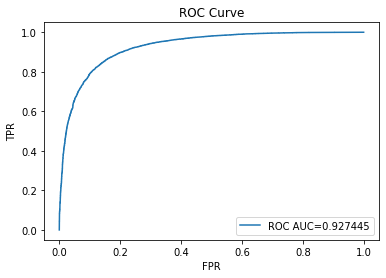

In [12]:
y_pred = clf.predict_proba(valid[variables])[:, 1]

assert valid.shape[0], y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

ROC AUC is just a part of the solution, we also have to make sure that

- the classifier output is not correlated with the mass
- classifier performs similarily on MC and real data of the normalization channel

### 1. Mass Correlation Check

In [13]:
df_corr_check = pd.read_csv("Data/check_correlation.csv.gz")

In [14]:
df_corr_check.shape

(5514, 48)

In [15]:
y_pred = clf.predict(df_corr_check[variables])

In [16]:
eff = get_efficiencies(y_pred, 
                       df_corr_check.mass, 
                       thresholds=[0.5]) # thresholds=[0.2, 0.4, 0.5, 0.6, 0.8])

In [17]:
eff.keys()

odict_keys([0.5])

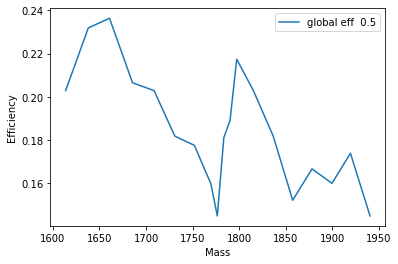

In [18]:
for label_name, eff_data in eff.items():
    plt.plot(eff_data[0], eff_data[1], label="global eff  %.1f" % label_name)

plt.xlabel('Mass')
plt.ylabel('Efficiency')
plt.legend();

In [19]:
corr_metric = check_correlation(y_pred, df_corr_check['mass'])
print(corr_metric)

0.00018672270203322103
